# Uncertainty Estimation

**Special thanks to Dr. Peyman Sheikhzadeh at the Tehran University Of Medical Science for providing this anonymized data**

In [1]:
import os
import numpy as np
from pytomography.io.SPECT import dicom
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform, CutOffTransform
from pytomography.algorithms import OSEM, BSREM
from pytomography.priors import RelativeDifferencePrior
from pytomography.priors import TopNAnatomyNeighbourWeight
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.utils import print_collimator_parameters
import matplotlib.pyplot as plt
import torch
from rt_utils import RTStructBuilder
from pytomography.callbacks import DataStorageCallback

In [2]:
save_path = '/disk1/pytomography_tutorial_data'

The following code cell loads projection data and a corresponding CT file and creates a reconstruction algorithm; if you are unfamiliar with the code below or require more explanation, see that "DICOM Data Introduction" tutorial.
* The collimator corresponding to this data is General Electric
s medium energy general purpose collimator.

In [3]:
file_NM = os.path.join(save_path, 'dicom_multibed_tutorial', 'bed2_projections.dcm')
path_CT = os.path.join(save_path, 'dicom_multibed_tutorial', 'CT')
files_CT = [os.path.join(path_CT, file) for file in os.listdir(path_CT)]
object_meta, proj_meta = dicom.get_metadata(file_NM, index_peak=1)
projections = dicom.get_projections(file_NM)
photopeak = projections[1].unsqueeze(0)
scatter = scatter = dicom.get_scatter_from_TEW(file_NM, index_peak=1, index_lower=3, index_upper=2)
# Build system matrix
attenuation_map = dicom.get_attenuation_map_from_CT_slices(files_CT, file_NM, index_peak=1)
psf_meta = dicom.get_psfmeta_from_scanner_params('GI-MEGP', energy_keV=208)
att_transform = SPECTAttenuationTransform(attenuation_map)
psf_transform = SPECTPSFTransform(psf_meta)
cutoff_transform = CutOffTransform(proj=projections)
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    proj2proj_transforms = [cutoff_transform],
    object_meta = object_meta,
    proj_meta = proj_meta)
photopeak = cutoff_transform.forward(photopeak)
scatter = cutoff_transform.forward(scatter)
# Likelihood
likelihood = PoissonLogLikelihood(system_matrix, photopeak, additive_term=scatter)
# Reconstruction algorithm
recon_algorithm = OSEM(likelihood)

Up to this point, we've created the reconstruction algorithm but we haven't performed reconstruction yet. If we plan on computing uncertainty in various VOIs, we are required to use the `DataStorageCallback` callback in the image reconstruction algorithm. This callback stores a copy of the reconstructed image at each iteration and subiteration: all this data is required when computing uncertainties later. It can be created as follows:

In [4]:
data_storage_callback = DataStorageCallback(likelihood, torch.clone(recon_algorithm.object_prediction))

Then we reconstruct using this callback:

In [5]:
recon_OSEM = recon_algorithm(n_iters = 20, n_subsets = 8, callback=data_storage_callback)

Here's a coronal slice of the reconstruction

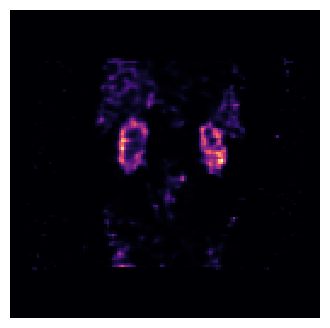

In [6]:
plt.figure(figsize=(4,4))
plt.pcolormesh(recon_OSEM[0,:,80].cpu().T, cmap='magma')
plt.axis('off')
plt.show()

Suppose we want to estimate the uncertainty in activity in one of the kidneys. Let's obtain it from an RTStruct file containing segmentations of all the organs. (The cell below is not required for this, but it will allow us to determine the mask names contained in the RTStruct file):

In [12]:
file_RT = os.path.join(save_path, 'dicom_multibed_tutorial', 'segmentations.dcm')
rtstruct = RTStructBuilder.create_from(
        dicom_series_path=path_CT, 
        rt_struct_path=file_RT
    )
print(rtstruct.get_roi_names())

['spleen', 'kidney_right', 'kidney_left', 'gallbladder', 'liver', 'stomach', 'pancreas', 'adrenal_gland_right', 'adrenal_gland_left', 'lung_upper_lobe_left', 'lung_lower_lobe_left', 'lung_upper_lobe_right', 'lung_middle_lobe_right', 'lung_lower_lobe_right', 'esophagus', 'trachea', 'thyroid_gland', 'small_bowel', 'duodenum', 'colon', 'urinary_bladder', 'sacrum', 'vertebrae_S1', 'vertebrae_L5', 'vertebrae_L4', 'vertebrae_L3', 'vertebrae_L2', 'vertebrae_L1', 'vertebrae_T12', 'vertebrae_T11', 'vertebrae_T10', 'vertebrae_T9', 'vertebrae_T8', 'vertebrae_T7', 'vertebrae_T6', 'vertebrae_T5', 'vertebrae_T4', 'vertebrae_T3', 'vertebrae_T2', 'vertebrae_T1', 'vertebrae_C7', 'vertebrae_C6', 'vertebrae_C5', 'vertebrae_C4', 'vertebrae_C3', 'vertebrae_C2', 'vertebrae_C1', 'heart', 'aorta', 'pulmonary_vein', 'brachiocephalic_trunk', 'subclavian_artery_right', 'subclavian_artery_left', 'common_carotid_artery_right', 'common_carotid_artery_left', 'brachiocephalic_vein_left', 'brachiocephalic_vein_right',

We can see the `'kidney_right'` is listed as one of the available masks. We can obtain this mask as follows:
* `file_RT` is the path to the RTStruct file
* `file_NM` is the path the the SPECT projection data; this is required for aligning the mask
* `dicom_series_path` is the reference DICOM path of the RTStruct
* `rt_struct_name` is the name of the RTStruct we wish to open

In [16]:
mask_name = 'kidney_left'
kidney_mask = dicom.get_aligned_rtstruct(
    file_RT = file_RT,
    file_NM = file_NM,
    dicom_series_path = path_CT,
    rt_struct_name = mask_name
)

We can compute the relative and absolute uncertainty corresponding to counts in this region using the `compute_uncertainty` function of the reconstruction algorithm. We also need to pass in the `DataStorageCallback` which contains every iterative update to the objects.

In [9]:
uncertainty_abs, uncertainty_pct = recon_algorithm.compute_uncertainty(
    mask = kidney_mask,
    data_storage_callback = data_storage_callback,
    return_pct = True
)
print(f'Estimated uncertainty in {mask_name}: {uncertainty_pct:.2f}%')

Estimated uncertainty in kidney_left: 0.98%


This can be repeated for any of the masks above! In addition, you can play around the with iterations, subsets (or even try different reconstruction algorithms) and see how it effects the estimated uncertainty.